In [1]:
# script to perturb 85 different amounts and get resulting ignition delays

In [24]:
import os
import sys
import copy

import datetime
import subprocess
import numpy as np

import rmgpy.chemkin
import rmgpy.data.kinetics
# import cantera as ct


import matplotlib.pyplot as plt
%matplotlib inline

sys.path.append('/work/westgroup/harris.se/autoscience/autoscience/utils')
import simulation

In [10]:
import importlib
importlib.reload(simulation)

<module 'simulation' from '/work/westgroup/harris.se/autoscience/autoscience/utils/simulation.py'>

In [19]:
def perturb_species(species, delta):
    # takes in an RMG species object
    # change the enthalpy offset
    for poly in species.thermo.polynomials:
        new_coeffs = poly.coeffs
        new_coeffs[5] *= (1.0 + delta)
        poly.coeffs = new_coeffs

In [22]:
def plot_thermos(thermos, labels=None):
    %matplotlib inline
    fig, ax = plt.subplots(1,3)
    fig.set_size_inches(12, 3)
    fig.tight_layout()
    ax[0].set_xlabel('Temperature (K)')
    ax[0].set_ylabel('H (kJ / mol)')
    ax[0].set_title('Enthalpy vs. Temperature')
    ax[1].set_xlabel('Temperature (K)')
    ax[1].set_ylabel('S (kJ / mol K)')
    ax[1].set_title('Entropy vs. Temperature')
    ax[2].set_xlabel('Temperature (K)')
    ax[2].set_ylabel('Cp (kJ / mol K)')
    ax[2].set_title('Heat Capacity vs. Temperature')
    T = np.linspace(300, 3000, 1001)
    for thermo in thermos:
        H = np.zeros(len(T))
        S = np.zeros(len(T))
        Cp = np.zeros(len(T))
        for i in range(0, len(T)):
            H[i] = thermo.get_enthalpy(T[i]) / 1000.0
            S[i] = thermo.get_entropy(T[i]) / 1000.0
            Cp[i] = thermo.get_heat_capacity(T[i]) / 1000.0
        ax[0].plot(T, H)
        ax[1].plot(T, S)
        ax[2].plot(T, Cp)
    ax[0].legend(labels)
    ax[1].legend(labels)
    ax[2].legend(labels)
    plt.subplots_adjust(wspace=0.25)
    plt.show()

In [17]:
# Load the base model
basedir = '/work/westgroup/harris.se/autoscience/autoscience/butane/models/rmg_model'
base_chemkin = os.path.join(basedir, 'chem_annotated.inp')
dictionary = os.path.join(basedir, 'species_dictionary.txt')
transport = os.path.join(basedir, 'tran.dat')
species_list, reaction_list = rmgpy.chemkin.load_chemkin_file(base_chemkin, dictionary_path=dictionary, transport_path=transport)
print(f'{len(species_list)} species, {len(reaction_list)} reactions')

# make a CTI and compute ignition delay
chemkin_file = 'temp_mech.inp'
cti_file = f'{chemkin_file[:-4]}.cti'
rmgpy.chemkin.save_chemkin_file(chemkin_file, species_list, reaction_list, verbose=True, check_for_duplicates=True)
subprocess.run(['ck2cti', f'--input={chemkin_file}', f'--transport={transport}', f'--output={cti_file}'])

# get ignition delay
base_delay = simulation.get_delay(cti_file)
print(f'Base delay:\t{base_delay}')

110 species, 1822 reactions
Wrote CTI mechanism file to 'temp_mech.cti'.
Mechanism contains 110 species and 1850 reactions.
Validating mechanism...PASSED.
Base delay:	0.1485753452497339


In [21]:
# Perturb 0.1
basedir = '/work/westgroup/harris.se/autoscience/autoscience/butane/models/rmg_model'
base_chemkin = os.path.join(basedir, 'chem_annotated.inp')
dictionary = os.path.join(basedir, 'species_dictionary.txt')
transport = os.path.join(basedir, 'tran.dat')
species_list, reaction_list = rmgpy.chemkin.load_chemkin_file(base_chemkin, dictionary_path=dictionary, transport_path=transport)
print(f'{len(species_list)} species, {len(reaction_list)} reactions')


perturb_species(species_list[85], 0.1)

# make a CTI and compute ignition delay
chemkin_file = 'temp_mech.inp'
cti_file = f'{chemkin_file[:-4]}.cti'
rmgpy.chemkin.save_chemkin_file(chemkin_file, species_list, reaction_list, verbose=True, check_for_duplicates=True)
subprocess.run(['ck2cti', f'--input={chemkin_file}', f'--transport={transport}', f'--output={cti_file}'])

# get ignition delay
base_delay = simulation.get_delay(cti_file)
print(f'delta=0.1 delay:\t{base_delay}')

110 species, 1822 reactions
Wrote CTI mechanism file to 'temp_mech.cti'.
Mechanism contains 110 species and 1850 reactions.
Validating mechanism...CanteraWarning: NasaPoly2::validate: 
For species S(787), discontinuity in h/RT detected at Tmid = 949.21
	Value computed using low-temperature polynomial:  -21.482586140525967
	Value computed using high-temperature polynomial: -21.715196799213427

PASSED.
For species S(787), discontinuity in h/RT detected at Tmid = 949.21
	Value computed using low-temperature polynomial:  -21.482586140525967
	Value computed using high-temperature polynomial: -21.715196799213427

delta=0.1 delay:	0.1744625610839329


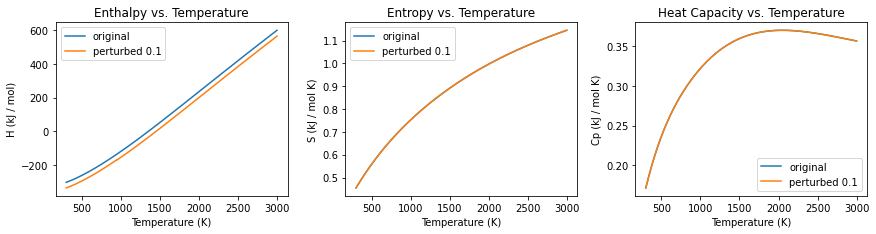

In [26]:
# plot the difference between the perturbed species 
perturbed_species = copy.deepcopy(species_list[85])

species_list, reaction_list = rmgpy.chemkin.load_chemkin_file(base_chemkin, dictionary_path=dictionary, transport_path=transport)

plot_thermos([species_list[85], perturbed_species], labels=['original', 'perturbed 0.1'])



In [18]:
# perturn the mechanism

In [ ]:
# # Load the new thermo library
# thermo_lib = os.path.join(DFT_DIR, 'thermo', 'thermo')
# ark_thermo_database = rmgpy.data.thermo.ThermoDatabase()
# ark_thermo_database.load_libraries(thermo_lib)
# print(f'{len(ark_thermo_database.libraries["harris_butane"].entries)} entries')